# Track football players with YOLOv5 + ByteTrack 

ByteTrack is a multi object tracker that identifies and identifies the trajectory of objects with accuracy.

In this notebook we will track football players on the field from YOLOv5 predictions.

Setup

In [ ]:
!git clone https://github.com/ifzhang/ByteTrack.git #Change all np.float to float as np.float has been deprecated
!pip3 install -r requirements.txt
!cd ByteTrack && python3 setup.py develop

fatal: destination path 'ByteTrack' already exists and is not an empty directory.
  Using cached ninja-1.11.1.1-py2.py3-none-manylinux1_x86_64.manylinux_2_5_x86_64.whl.metadata (5.3 kB)
  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
  Using cached motmetrics-1.4.0-py3-none-any.whl.metadata (20 kB)
  Using cached filterpy-1.4.5-py3-none-any.whl
  Using cached onnx-1.8.1.tar.gz (5.2 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [20 lines of output]
      <string>:32: DeprecationWarning: Use shutil.which instead of find_executable
      <string>:33: DeprecationWarning: Use shutil.which instead of find_executable
      fatal: not a git repository (or any of the parent directories): .git
      Traceback (most recent call last):
        File "/home/varivashyap/vashya/.venv/lib/python3.10/site-packages

In [4]:
import sys
sys.path.append("ByteTrack")

In [5]:
from yolox.tracker.byte_tracker import BYTETracker
import cv2
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from pathlib import Path
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass
from typing import List, Optional

Load the video

In [6]:
def get_video_frames(video_path):

    video = cv2.VideoCapture(str(video_path))

    frames = []
    while video.isOpened():
        success, frame = video.read()
        if not success:
            break
        frames.append(frame)

    video.release()

    return frames

In [7]:
video_path = Path("/home/varivashyap/vashya/Football-Players-Tracking/hi/hi/Input1.mp4")

In [8]:
frames = get_video_frames(video_path)

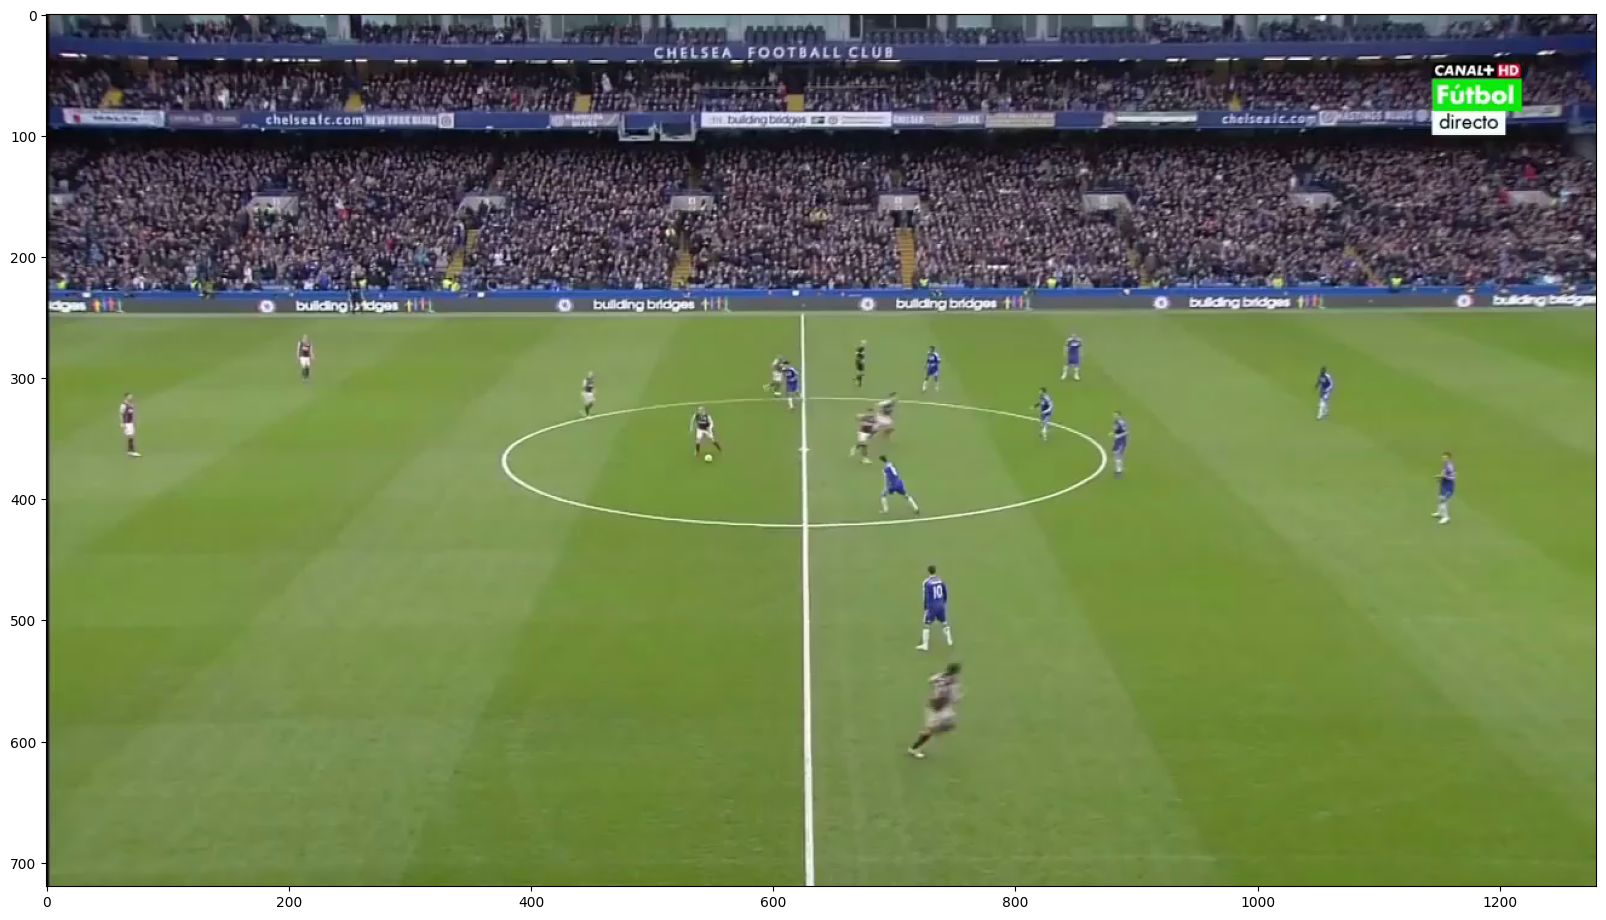

True

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(frames[0], cv2.COLOR_BGR2RGB))
plt.show()

# Save the image

cv2.imwrite("frame.jpg", frames[0])

Load YOLOv5

In [ ]:
path_weights = "/home/varivashyap/vashya/best300.pt" #Change the path to the weights file
yolo_model = torch.hub.load('ultralytics/yolov5', 'custom', path_weights, device="cpu", force_reload=True)

HTTPError: HTTP Error 403: rate limit exceeded

In [ ]:
ind_to_cls = {
    0: "ball",
    1 : "goalkeeper",
    2 : "player",
    3 : "referee"
}

colors = {
    "ball": (0,200,200), # yellow
    "player": (255,0,0), # blue
    "goalkeeper":(255,0,255), # magenta
    "referee": (0,0,255) # red
}

colors1 = {
  "Team1" : (0, 0, 0),
  "Team2" : (255, 255, 255)
}

@dataclass
class Detection:
    xywh: List[float]
    xyxy: List[float]
    class_id: int
    class_name: str
    confidence: float
    tracker_id: Optional[int] = None

    @classmethod
    def from_results(cls, pred):
        result = []
        for x_min, y_min, x_max, y_max, confidence, class_id in pred:
            class_id=int(class_id)
            result.append(Detection(
                xywh=[float(x_min), float(y_min), float(x_max - x_min), float(y_max - y_min)],
                xyxy=[float(x_min), float(y_min), float(x_max), float(y_max)],
                class_id=class_id,
                class_name=ind_to_cls[class_id],
                confidence=float(confidence)
            ))
        return result
    
def draw_detections(image, detections, draw_tacker_id: bool = False):
  image = image.copy()
  for pred in detections:
    bbox = pred.xyxy
    cls = pred.class_name
    cv2.rectangle(img=image, pt1=tuple([int(b) for b in bbox[:2]]), pt2=tuple([int(b) for b in bbox[2:]]), color=colors[cls], thickness=3)
    
    # center_bottom = (int((bbox[0] + bbox[2]) / 2), int(bbox[3]))
    # bbox_width = int(bbox[2] - bbox[0])
    
    # Draw an ellipse at the bottom center of the bounding box
    #cv2.ellipse(image, center_bottom, (bbox_width // 2, 8), 0, 0, 180, color=colors[cls], thickness=3)
        
    if draw_tacker_id and cls != "ball":
      cv2.putText(image, str(pred.tracker_id), (int(bbox[0]), int(bbox[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, colors[cls], 3)
    else:
      cv2.putText(image, cls, (int(bbox[0]), int(bbox[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, colors[cls], 3)

  return image

prediction = yolo_model(frames[0]).pred[0].cpu().numpy()

image = draw_detections(frames[0], Detection.from_results(prediction))

plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.grid(False)
plt.show()

# Save the image

cv2.imwrite("detections.jpg", image)

/home/varivashyap/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


True

In [ ]:
# from sklearn.cluster import KMeans
# import numpy as np

# ind_to_cls = {
#     0: "ball",
#     1 : "goalkeeper",
#     2 : "player",
#     3 : "referee"
# }

# colors = {
#     "ball": (0,200,200), # yellow
#     "player": (255,0,0), # blue
#     "goalkeeper":(255,0,255), # magenta
#     "referee": (0,0,255) # red
# }

# colors1 = {
#   "Team1" : (0, 0, 225),
#   "Team2" : (255, 0, 0)
# }

# # def identify_team_color(image, bbox):
# #     """
# #     Identify the team color of the player based on the bounding box region.
# #     """
# #     # Extract the region within the bounding box
# #     x_min, y_min, x_max, y_max = map(int, bbox)
# #     player_roi = image[y_min:y_max, x_min:x_max]

# #     # Reshape the ROI to a list of pixels
# #     pixels = player_roi.reshape(-1, 3)

# #     # Apply K-means clustering to find the dominant color (assuming 2 clusters)
# #     kmeans = KMeans(n_clusters=2, random_state=0).fit(pixels)
# #     dominant_color = kmeans.cluster_centers_[kmeans.labels_[0]].astype(int)

# #     # Define color thresholds for Team1 and Team2 (black and white in this example)
# #     team1_color = np.array([0, 0, 0])       # Color for Team1 (black)
# #     team2_color = np.array([255, 255, 255]) # Color for Team2 (white)

# #     # Calculate distance to each team color
# #     dist_to_team1 = np.linalg.norm(dominant_color - team1_color)
# #     dist_to_team2 = np.linalg.norm(dominant_color - team2_color)

# #     # Assign team based on the closest color match
# #     return "Team1" if dist_to_team1 < dist_to_team2 else "Team2"

# @dataclass
# class Detection:
#     xywh: List[float]
#     xyxy: List[float]
#     class_id: int
#     class_name: str
#     confidence: float
#     tracker_id: Optional[int] = None

#     @classmethod
#     def from_results(cls, pred, image):
#         result = []
#         for x_min, y_min, x_max, y_max, confidence, class_id in pred:
#             class_id = int(class_id)
#             detection = Detection(
#                 xywh=[float(x_min), float(y_min), float(x_max - x_min), float(y_max - y_min)],
#                 xyxy=[float(x_min), float(y_min), float(x_max), float(y_max)],
#                 class_id=class_id,
#                 class_name=ind_to_cls[class_id],
#                 confidence=float(confidence)
#             )
#             result.append(detection)
#         return result

# def draw_detections(image, detections, draw_tracker_id: bool = False):
    
#     image = image.copy()
#     for pred in detections:
#         bbox = pred.xyxy
#         cls = pred.class_name
#         x_min, y_min, x_max, y_max = map(int, bbox)
#         player_roi = image[y_min:y_max, x_min:x_max]

#         # Reshape the ROI to a list of pixels
#         pixels = player_roi.reshape(-1, 3)

#         # Apply K-means clustering to find the dominant color (assuming 2 clusters)
#         kmeans = KMeans(n_clusters=2, random_state=0).fit(pixels)
#         dominant_color = kmeans.cluster_centers_[kmeans.labels_[0]].astype(int)

#         # Define color thresholds for Team1 and Team2 (black and white in this example)
#         team1_color = np.array([0, 0, 0])       # Color for Team1 (black)
#         team2_color = np.array([255, 255, 255]) # Color for Team2 (white)

#         # Calculate distance to each team color
#         dist_to_team1 = np.linalg.norm(dominant_color - team1_color)
#         dist_to_team2 = np.linalg.norm(dominant_color - team2_color)

#         team = "Team1" if dist_to_team1 < dist_to_team2 else "Team2"
    
#         # Draw the bounding ellipse or box
#         center_bottom = (int((bbox[0] + bbox[2]) / 2), int(bbox[3]))
#         bbox_width = int(bbox[2] - bbox[0])
       
#         cv2.ellipse(image, center_bottom, (bbox_width // 2, 8), 0, 0, 180, color=colors[cls], thickness=1)
        
#         if draw_tracker_id and cls != "ball":
#             cv2.putText(image, f"{pred.tracker_id}", (int(bbox[0]), int(bbox[1]) - 10),
#                         cv2.FONT_HERSHEY_SIMPLEX, 0.9, colors1[team], 3)
#         else:
#             cv2.putText(image, cls, (int(bbox[0]), int(bbox[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, colors1[team], 3)

#     return image

# # Usage example
# prediction = yolo_model(frames[0]).pred[0].cpu().numpy()
# image = draw_detections(frames[0], Detection.from_results(prediction, frames[0]))


# plt.figure(figsize=(20, 20))
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# plt.grid(False)
# plt.show()

# # Save the image

# cv2.imwrite("detections1.jpg", image)


## Create ByteTracker

ByteTrack creates trackers that are identified and attempts to find their trajectory across the frames.  
Also it expects the detection to have this format: (x1, y1, x2, y2, conf).

So we need to convert yolo detections to ByteTrack format and also identify they correspond to which tracker that is followed by ByteTrack.

In [ ]:
from dataclasses import dataclass

@dataclass(frozen=True)
class BYTETrackerArgs:
  track_thresh: float = 0.25
  track_buffer: int = 30
  match_thresh: float = 0.8
  aspect_ratio_thresh: float = 3.0
  min_box_area: float = 1.0
  mot20: bool = False

In [ ]:
# initiate tracker
byte_tracker = BYTETracker(BYTETrackerArgs)

In [ ]:
def format_predictions(predictions, with_conf: bool = True):
  """
  Format yolo detection to ByteTracke format: (x1, y1, x2, y2, conf)
  """
  frame_detections = []
  for pred in predictions:
      bbox = pred.xyxy
      conf = pred.confidence
      if with_conf:
        detection = bbox + [conf]
      else:
        detection = bbox

      frame_detections.append(detection)
  return np.array(frame_detections, dtype=float)


In [ ]:
def match_detections_with_tracks(detections, tracks):
  """
  Find which tracker corresponds to yolo detections and set the tracker_id.
  We compute the iou between the detection and trackers.
  """
  detections_bboxes = format_predictions(detections, with_conf=False)
  tracks_bboxes = np.array([track.tlbr for track in tracks], dtype=float)
  iou = box_iou_batch(tracks_bboxes, detections_bboxes)
  track2detection = np.argmax(iou, axis=1)

  for tracker_index, detection_index in enumerate(track2detection):
    if iou[tracker_index, detection_index] != 0:
      detections[detection_index].tracker_id = tracks[tracker_index].track_id
  return detections

In [ ]:
def get_video_writer(output_video_path, fps, width, height):
  """
  Create a video writer to save new frames after annotation
  """
  output_video_path.parent.mkdir(exist_ok=True)
  return cv2.VideoWriter(
      str(output_video_path),
      fourcc=cv2.VideoWriter_fourcc(*"mp4v"),
      fps=fps,
      frameSize=(width, height),
      isColor=True
  )

Track players and save to video

In [ ]:
output_video_path = Path("output.mp4") #Change the path to the output video file

video_writer = get_video_writer(
    output_video_path,
    30, # You can choose the fps
    frames[0].shape[1],
    frames[0].shape[0]
)

In [ ]:
for frame in tqdm(frames[:400]): #You can choose the number of frames to process

    # detect players with yolo
    detections = yolo_model(frame).pred[0].cpu().numpy()

    detections = Detection.from_results(detections)

    # create a new list of detection with tracker_id attribute.
    detections_with_tracker = []
    for detection in detections:
      detection.tracker_id = ""
      detections_with_tracker.append(detection)

    # get trackers with ByteTrack
    tracks = byte_tracker.update(
        output_results=format_predictions(detections_with_tracker, with_conf=True),
        img_info=frame.shape,
        img_size=frame.shape
    )

    # set tracker_id in yolo detections
    detections_with_tracker = match_detections_with_tracks(detections_with_tracker, tracks)

    # annotate the frame
    image = draw_detections(frame, detections_with_tracker, True)

    # save the frame to video writer
    video_writer.write(image)

# save the video
video_writer.release()

  0%|          | 0/400 [00:00<?, ?it/s]/home/varivashyap/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/varivashyap/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
  0%|          | 2/400 [00:00<00:20, 19.23it/s]/home/varivashyap/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/varivashyap/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instea